# Introduction


* Project: University of Liverpool - Ion Switching
* Objective : Identify the number of channels open at each time point.
* Description : 
When ion channels open, they pass electric currents. Existing methods of detecting these state changes are slow and laborious. Humans must supervise the analysis, which imparts considerable bias, in addition to being tedious. These difficulties limit the volume of ion channel current analysis that can be used in research. Scientists hope that technology could enable rapid automatic detection of ion channel current events in raw data.

* Website : https://www.kaggle.com/c/liverpool-ion-switching
* Notebook : https://www.kaggle.com/code/kmat2019/u-net-1d-cnn-with-keras/notebook

In this kernel, I'd like to share the approach using 1D Convolutional Neural Networks(1D CNN). 1D CNN is sometimes effective to analyze time series data. This kernel introduces U-Net architecture with 1D CNN.

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline 

import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Reshape, Conv1D, BatchNormalization, Activation, AveragePooling1D, GlobalAveragePooling1D, Lambda, Input, Concatenate, Add, UpSampling1D, Multiply
from tensorflow.keras.models import Model
#from tensorflow.keras.objectives import mean_squared_error
#from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.initializers import random_normal
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import KFold, train_test_split

In [2]:
datadir = '/tf/dataset/' #docker

In [3]:
df_train = pd.read_csv(os.path.join( datadir, "liverpool-ion-switching/train.csv"))
df_test = pd.read_csv(os.path.join( datadir, "liverpool-ion-switching/test.csv"))

In [4]:
df_train

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0
...,...,...,...
4999995,499.9996,2.9194,7
4999996,499.9997,2.6980,7
4999997,499.9998,4.5164,8
4999998,499.9999,5.6397,9


In [5]:
signal = df_train['signal'].values


In [6]:
signal.shape

(5000000,)

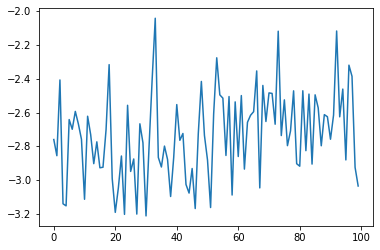

In [7]:
plt.plot(signal[:100])


# Split

Simply split the input data into certain length.

In [8]:
# I don't use "time" feature
# number_of_data:1250 x time_step:4000
train_input = df_train["signal"].values.reshape(-1,4000,1)

In [9]:
train_input_mean = train_input.mean()
train_input_sigma = train_input.std()
train_input = (train_input-train_input_mean)/train_input_sigma
test_input = df_test["signal"].values.reshape(-1,10000,1)#
test_input = (test_input-train_input_mean)/train_input_sigma

In [10]:
print(train_input.shape)
print(test_input.shape)

(1250, 4000, 1)
(200, 10000, 1)


In [11]:
df_train["open_channels"].unique()

array([ 0,  1,  3,  2, 10,  9,  8,  7,  6,  5,  4])

In [12]:
n_classes = len(df_train["open_channels"].unique())
print(n_classes)

11


In [13]:
train_target = pd.get_dummies(df_train["open_channels"]).values.reshape(-1,4000,n_classes)#classification

print(train_input.shape) #before split
idx = np.arange(train_input.shape[0])

train_idx, val_idx = train_test_split(idx, random_state = 111,test_size = 0.2)

val_input = train_input[val_idx]
train_input = train_input[train_idx] 

val_target = train_target[val_idx]
train_target = train_target[train_idx] 

print(train_input.shape) #after split

(1250, 4000, 1)
(1000, 4000, 1)


In [14]:
print("train_input:{}, val_input:{}, train_target:{}, val_target:{}".format(train_input.shape, val_input.shape, train_target.shape, val_target.shape))

train_input:(1000, 4000, 1), val_input:(250, 4000, 1), train_target:(1000, 4000, 11), val_target:(250, 4000, 11)


# Define Model

This section defines U-Net(se-resnet base). Input and output of the U-Net are follows:

* Input: 4000 time steps of "signal"
* Output: 4000 time steps of 11 class "open_channels"

I've changed the model from regressor to classifier at version 3. So the output has the multi class.

In [15]:
def cbr(x, out_layer, kernel, stride, dilation):
    x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def se_block(x_in, layer_n):
    x = GlobalAveragePooling1D()(x_in)
    x = Dense(layer_n//8, activation="relu")(x)
    x = Dense(layer_n, activation="sigmoid")(x)
    x_out=Multiply()([x_in, x])
    return x_out

def resblock(x_in, layer_n, kernel, dilation, use_se=True):
    x = cbr(x_in, layer_n, kernel, 1, dilation)
    x = cbr(x, layer_n, kernel, 1, dilation)
    if use_se:
        x = se_block(x, layer_n)
    x = Add()([x_in, x])
    return x  

def Unet(input_shape=(None,1)):
    layer_n = 64
    kernel_size = 3#7
    depth = 2

    input_layer = Input(input_shape)    
    input_layer_1 = AveragePooling1D(5)(input_layer)
    input_layer_2 = AveragePooling1D(25)(input_layer)
    
    ########## Encoder
    x = cbr(input_layer, layer_n, kernel_size, 1, 1)#1000
    for i in range(depth):
        x = resblock(x, layer_n, kernel_size, 1)
    out_0 = x

    x = cbr(x, layer_n*2, kernel_size, 5, 1)
    for i in range(depth):
        x = resblock(x, layer_n*2, kernel_size, 1)
    out_1 = x

    x = Concatenate()([x, input_layer_1])    
    x = cbr(x, layer_n*3, kernel_size, 5, 1)
    for i in range(depth):
        x = resblock(x, layer_n*3, kernel_size, 1)
    out_2 = x

    x = Concatenate()([x, input_layer_2])    
    x = cbr(x, layer_n*4, kernel_size, 5, 1)
    for i in range(depth):
        x = resblock(x, layer_n*4, kernel_size, 1)
    
    ########### Decoder
    x = UpSampling1D(5)(x)
    x = Concatenate()([x, out_2])
    x = cbr(x, layer_n*3, kernel_size, 1, 1)

    x = UpSampling1D(5)(x)
    x = Concatenate()([x, out_1])
    x = cbr(x, layer_n*2, kernel_size, 1, 1)

    x = UpSampling1D(5)(x)
    x = Concatenate()([x, out_0])
    x = cbr(x, layer_n, kernel_size, 1, 1)    

    #regressor
    #x = Conv1D(1, kernel_size=kernel_size, strides=1, padding="same")(x)
    #out = Activation("sigmoid")(x)
    #out = Lambda(lambda x: 12*x)(out)
    
    #classifier
    x = Conv1D(11, kernel_size=kernel_size, strides=1, padding="same")(x)
    out = Activation("softmax")(x)
    
    model = Model(input_layer, out)
    
    return model


def augmentations(input_data, target_data):
    #flip
    if np.random.rand()<0.5:    
        input_data = input_data[::-1]
        target_data = target_data[::-1]

    return input_data, target_data


def Datagen(input_dataset, target_dataset, batch_size, is_train=False):
    x=[]
    y=[]
  
    count=0
    idx_1 = np.arange(len(input_dataset))
    #idx_2 = np.arange(len(input_dataset))
    np.random.shuffle(idx_1)
    #np.random.shuffle(idx_2)

    while True:
        for i in range(len(input_dataset)):
            input_data = input_dataset[idx_1[i]]
            target_data = target_dataset[idx_1[i]]
            #input_data_mix = input_dataset[idx_2[i]]
            #target_data_mix = target_dataset[idx_2[i]]

            if is_train:
                input_data, target_data = augmentations(input_data, target_data)
                #input_data_mix, target_data_mix = augmentations(input_data_mix, target_data_mix)
                
            x.append(input_data)
            y.append(target_data)
            count+=1
            if count==batch_size:
                x=np.array(x, dtype=np.float32)
                y=np.array(y, dtype=np.float32)
                inputs = x
                targets = y       
                x = []
                y = []
                count=0
                yield inputs, targets

class macroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=2).reshape(-1)

    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis=2).reshape(-1)
        f1_val = f1_score(self.targets, pred, average="macro")
        print("val_f1_macro_score: ", f1_val)
                
def model_fit(model, train_inputs, train_targets, val_inputs, val_targets, n_epoch, batch_size=32):
    hist = model.fit_generator(
        Datagen(train_inputs, train_targets, batch_size, is_train=True),
        steps_per_epoch = len(train_inputs) // batch_size,
        epochs = n_epoch,
        validation_data=Datagen(val_inputs, val_targets, batch_size),
        validation_steps = len(val_inputs) // batch_size,
        callbacks = [lr_schedule, macroF1(model, val_inputs, val_targets)],
        shuffle = False,
        verbose = 1
        )
    return hist


def lrs(epoch):
    if epoch<35:
        lr = learning_rate
    elif epoch<50:
        lr = learning_rate/10
    else:
        lr = learning_rate/100
    return lr

In [16]:
#K.clear_session()
model = Unet()
#print(model.summary())

learning_rate=0.0005
n_epoch=60
batch_size=32

lr_schedule = LearningRateScheduler(lrs)

#regressor
#model.compile(loss="mean_squared_error", 
#              optimizer=Adam(lr=learning_rate),
#              metrics=["mean_absolute_error"])

#classifier
model.compile(loss=categorical_crossentropy, 
              optimizer=Adam(lr=learning_rate), 
              metrics=["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 64)     256         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, None, 64)    256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, None, 64)     0           ['batch_normalization[0][0]']

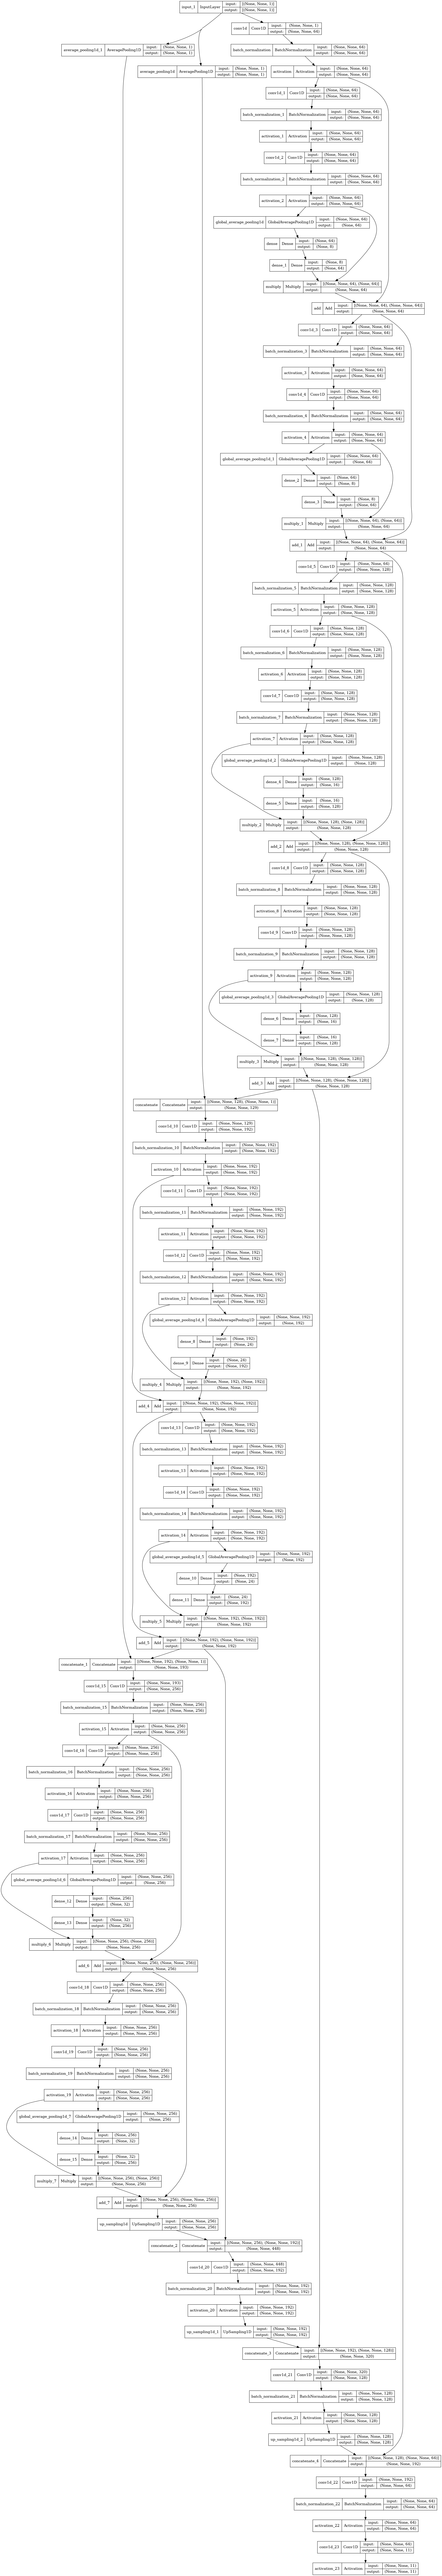

In [18]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [19]:
hist = model.fit_generator(
        Datagen( train_input, train_target, batch_size, is_train=True),
        steps_per_epoch = len(train_input) // batch_size,
        epochs = n_epoch,
        validation_data=Datagen(val_input, val_target, batch_size),
        validation_steps = len(val_input) // batch_size,
        callbacks = [lr_schedule, macroF1(model, val_input, val_target)],
        shuffle = False,
        verbose = 1
        )

<ipython-input-19-5ba96fd99e94>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/60
31/31 [==============================] - 10s 134ms/step - loss: 1.5169 - accuracy: 0.4871 - val_loss: 2.1167 - val_accuracy: 0.1927 - lr: 5.0000e-04
Epoch 2/60
31/31 [==============================] - 3s 92ms/step - loss: 1.0857 - accuracy: 0.6037 - val_loss: 2.2990 - val_accuracy: 0.1950 - lr: 5.0000e-04
Epoch 3/60
31/31 [==============================] - 3s 90ms/step - loss: 0.9351 - accuracy: 0.6475 - val_loss: 2.2439 - val_accuracy: 0.2713 - lr: 5.0000e-04
Epoch 4/60
31/31 [==============================] - 3s 89ms/step - loss: 0.8892 - accuracy: 0.6647 - val_loss: 4.4717 - val_accuracy: 0.2336 - lr: 5.0000e-04
Epoch 5/60
31/31 [==============================] - 3s 83ms/step - loss: 0.7400 - accuracy: 0.7237 - val_loss: 4.8983 - val_accuracy: 0.2408 - lr: 5.0000e-04
Epoch 6/60
31/31 [==============================] - 3s 87ms/step - loss: 0.6582 - accuracy: 0.7550 - val_loss: 4.6905 - val_accuracy: 0.2524 - lr: 5.0000e-04
Epoch 7/60
31/31 [==============================] 

31/31 [==============================] - 3s 92ms/step - loss: 0.2320 - accuracy: 0.9160 - val_loss: 0.4651 - val_accuracy: 0.8321 - lr: 5.0000e-04
Epoch 31/60
31/31 [==============================] - 3s 88ms/step - loss: 0.2337 - accuracy: 0.9154 - val_loss: 0.7470 - val_accuracy: 0.7890 - lr: 5.0000e-04
Epoch 32/60
31/31 [==============================] - 3s 90ms/step - loss: 0.2400 - accuracy: 0.9141 - val_loss: 0.5084 - val_accuracy: 0.8380 - lr: 5.0000e-04
Epoch 33/60
31/31 [==============================] - 3s 90ms/step - loss: 0.2103 - accuracy: 0.9260 - val_loss: 0.3176 - val_accuracy: 0.8917 - lr: 5.0000e-04
Epoch 34/60
31/31 [==============================] - 3s 90ms/step - loss: 0.1903 - accuracy: 0.9328 - val_loss: 0.2559 - val_accuracy: 0.9090 - lr: 5.0000e-04
Epoch 35/60
31/31 [==============================] - 3s 86ms/step - loss: 0.2050 - accuracy: 0.9280 - val_loss: 0.3714 - val_accuracy: 0.8614 - lr: 5.0000e-04
Epoch 36/60
31/31 [==============================] - 3s 89

31/31 [==============================] - 3s 91ms/step - loss: 0.1540 - accuracy: 0.9474 - val_loss: 0.1761 - val_accuracy: 0.9352 - lr: 5.0000e-06
Epoch 60/60
31/31 [==============================] - 3s 88ms/step - loss: 0.1562 - accuracy: 0.9469 - val_loss: 0.1783 - val_accuracy: 0.9340 - lr: 5.0000e-06


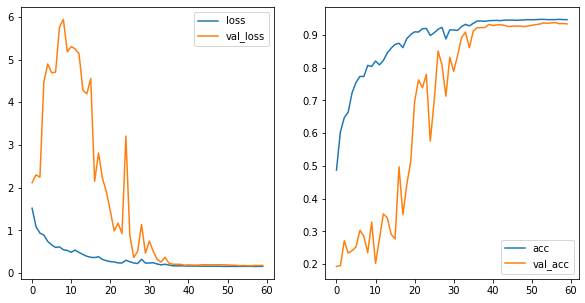

In [35]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])

In [20]:
gt = np.argmax(val_target, axis=2).reshape(-1)
print(val_target.shape)
print(gt.shape)
print(gt[:20])
print(gt[-20:])

(250, 4000, 11)
(1000000,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0]


In [21]:
pred1 = model.predict(val_input)
pred1.shape

(250, 4000, 11)

In [22]:
pred2 =model.predict(val_input[:,::-1,:])[:,::-1,:] # == 역순으로

pred2.shape

(250, 4000, 11)

In [23]:
pred12 = (model.predict(val_input)+model.predict(val_input[:,::-1,:])[:,::-1,:])/2
pred12.shape

(250, 4000, 11)

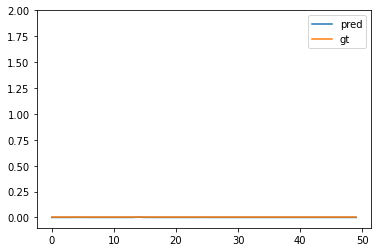

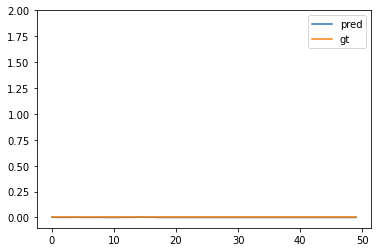

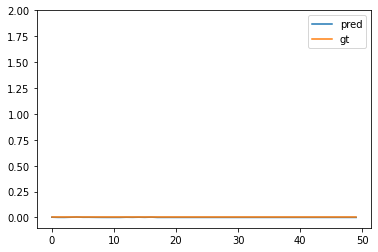

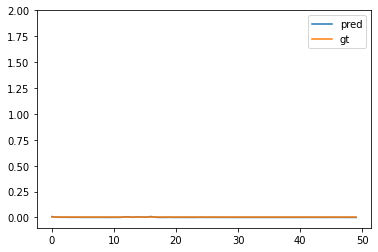

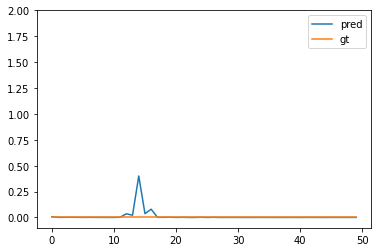

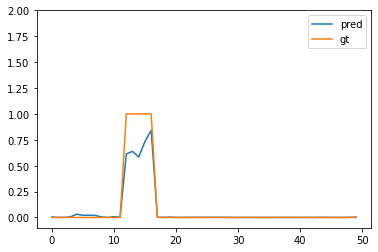

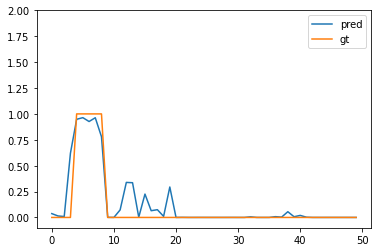

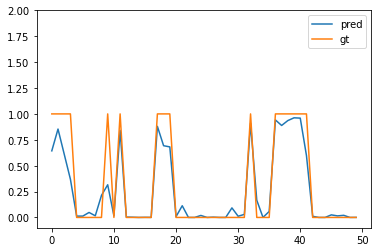

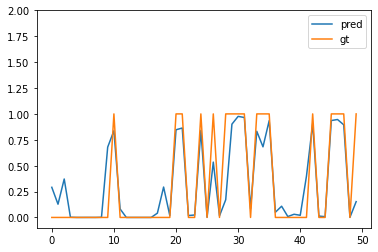

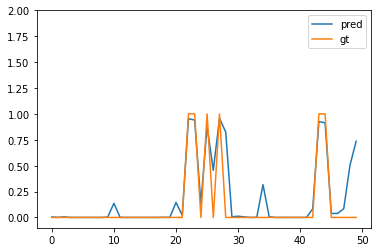

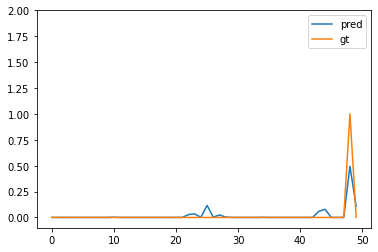

In [24]:
#plt.plot(pred12[0, :, 0])
idx_disp = 11
for ch in range(n_classes):#ch = 8
    plt.figure()
    plt.plot(pred12[idx_disp, :50, ch])
    plt.plot(val_target[idx_disp, :50, ch])
    plt.legend(['pred', 'gt'])
    plt.ylim(-0.1,2)

In [25]:
pred = np.argmax((model.predict(val_input)+model.predict(val_input[:,::-1,:])[:,::-1,:])/2, axis=2).reshape(-1)

print("SCORE_oldmetric: ", cohen_kappa_score(gt, pred, weights="quadratic"))
print("SCORE_newmetric: ", f1_score(gt, pred, average="macro"))

SCORE_oldmetric:  0.9956606537167568
SCORE_newmetric:  0.8948162156325433


In [26]:
pred = np.argmax((model.predict(test_input)+model.predict(test_input[:,::-1,:])[:,::-1,:])/2, axis=2).reshape(-1)
print(pred.shape)
df_sub = pd.read_csv(os.path.join( datadir, "liverpool-ion-switching/sample_submission.csv"), dtype={'time':str})
df_sub.open_channels = np.array(np.round(pred,0), np.int)
df_sub.to_csv("submission.csv",index=False)

(2000000,)


<ipython-input-26-a851c6587e50>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_sub.open_channels = np.array(np.round(pred,0), np.int)
